In [107]:

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import torch
import random
from tqdm import tqdm

In [2]:
os.chdir('/home/gptrapletti/ds/satellite-multiclass-segm')

# <ins> FUNCTION TO TURN MASK PNGS TO SEMANTIC MASK ARRAYS

In [3]:
image_filepaths = sorted([os.path.join('data/images', filename) for filename in os.listdir(os.path.join('data/images'))])
mask_filepaths = sorted([os.path.join('data/masks', filename) for filename in os.listdir(os.path.join('data/masks'))])

len(image_filepaths), len(mask_filepaths)

(400, 400)

In [7]:
mask = cv2.imread(mask_filepaths[55])
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

mask.shape

(4000, 6000, 3)

In [22]:
category_colors = {
'background': [(112, 150, 146),
  (2, 135, 115),
  (9, 143, 150),
  (0, 0, 0),
  (119, 11, 32),
  (102, 51, 0),
  (255, 0, 0),
  (190, 153, 153),
  (0, 50, 89),
  (153, 153, 153)],
 'ground': [(128, 64, 128), (112, 103, 87), (130, 76, 0), (48, 41, 30)],
 'vegetation': [(0, 102, 0), (107, 142, 35), (51, 51, 0), (190, 250, 190)],
 'buildings': [(70, 70, 70), (102, 102, 156), (254, 228, 12), (254, 148, 12)],
 'water': [(28, 42, 168)],
 'person': [(255, 22, 96)]}

category_ids = {
    'background': 0,
    'ground': 1,
    'vegetation': 2,
    'buildings': 3,
    'water': 4,
    'person': 5
}

In [21]:
b = np.all(mask == [128, 64, 128], axis=2)
b.shape

(4000, 6000)

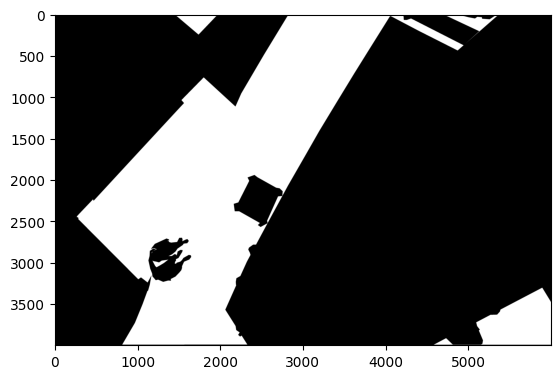

In [18]:
plt.imshow(b, cmap='gray')

In [23]:
for category in category_colors:
    for color in category_colors[category]:
        color_is_present = np.all(mask == color, axis=2)
        mask[color_is_present] = category_ids[category]      

In [24]:
mask.shape

(4000, 6000, 3)

In [25]:
np.unique(mask)

array([0, 1, 2, 3, 5], dtype=uint8)

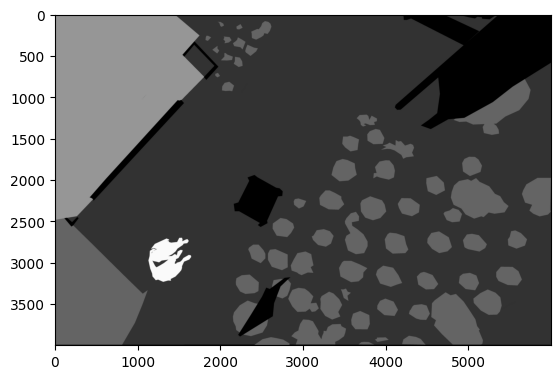

In [29]:
plt.imshow(mask * 50)

In [32]:
np.all(mask[..., 1] == mask[..., 2])

True

In [34]:
np.unique(mask).tolist()

[0, 1, 2, 3, 5]

# <INS> FIND OUT IF DATASET CAN RETURN SINGLE PATCHES

In [65]:
# It doesn't work this way
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = list(range(1, 10+1))

    def __getitem__(self, index):
        number = self.data[index]
        for i in range(1, 5+1):
            patch = number + i/10
            return patch
            

    def __len__(self):
        return len(self.data)*10
    
dataset = DummyDataset()

mylist = list(dataset)

mylist

[1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1]

In [76]:
# To simulate computing bounding boxes coordinates before hand and then return a single patch
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = list(range(1, 10+1))
        self.bounding_boxes = self.get_elements(self.data) 

    def __getitem__(self, index):
        return self.bounding_boxes[index]
            
    def get_elements(self, data):
        l = []
        for d in data:
            for i in range(1, 5+1):
                l.append(d + i/10)
        
        return l

    def __len__(self):
        return len(self.data)
    
dataset = DummyDataset()

mylist = list(dataset)

mylist

[1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 2.1,
 2.2,
 2.3,
 2.4,
 2.5,
 3.1,
 3.2,
 3.3,
 3.4,
 3.5,
 4.1,
 4.2,
 4.3,
 4.4,
 4.5,
 5.1,
 5.2,
 5.3,
 5.4,
 5.5,
 6.1,
 6.2,
 6.3,
 6.4,
 6.5,
 7.1,
 7.2,
 7.3,
 7.4,
 7.5,
 8.1,
 8.2,
 8.3,
 8.4,
 8.5,
 9.1,
 9.2,
 9.3,
 9.4,
 9.5,
 10.1,
 10.2,
 10.3,
 10.4,
 10.5]

Let's try it with the satellite data

In [ ]:
image_filepaths = sorted([os.path.join('data/images', filename) for filename in os.listdir(os.path.join('data/images'))])
mask_filepaths = sorted([os.path.join('data/masks', filename) for filename in os.listdir(os.path.join('data/masks'))])

len(image_filepaths), len(mask_filepaths)

(400, 400)

In [77]:
image = torch.rand((3, 1500, 2000))

image.shape

torch.Size([3, 1500, 2000])

In [81]:
def get_random_bbox_coords(side, max_height, max_width):
    top_left = random.randint(0, max_height - side), random.randint(0, max_width - side)
    bottom_right = top_left[0] + side, top_left[1] + side
    return (top_left, bottom_right)

In [119]:
# Too slow! For every patch the image is loaded again
class MyDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        image_filepaths,
    ):
        super().__init__()
        self.image_filepaths = image_filepaths
        self.n_patch_per_image = 100
        self.patch_bboxs = self.generate_patch_bboxs()
           
    def get_random_bbox_coords(self, side, max_height, max_width):
        top_left = random.randint(0, max_height - side), random.randint(0, max_width - side)
        bottom_right = top_left[0] + side, top_left[1] + side
        return (top_left, bottom_right)
    
    def generate_patch_bboxs(self):
        patch_bboxs = []
        for i in range(len(self.image_filepaths)):
            for j in range(self.n_patch_per_image):
                filepath = image_filepaths[i]
                bbox = self.get_random_bbox_coords(side=256, max_height=2000, max_width=3000)
                patch_bboxs.append((filepath, bbox))
        
        return patch_bboxs
                
    def __getitem__(self, idx):
        filepath = self.patch_bboxs[idx][0]
        bbox = self.patch_bboxs[idx][1]
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (3000, 2000)) # cv2 wants tuple (width, height)
        patch = image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :]
        return patch

    def __len__(self):
        return len(self.patch_bboxs)           
    
    
    

In [120]:
dataset = MyDataset(image_filepaths=image_filepaths[:300])
len(dataset.patch_bboxs)

30000

4574 (256, 256, 3)


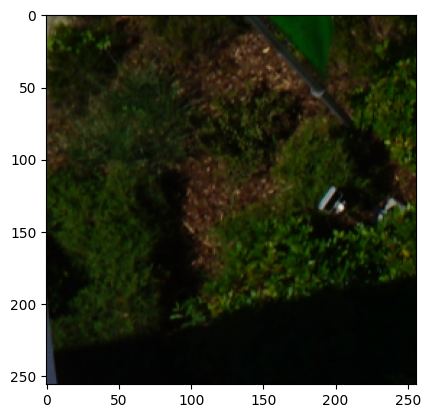

In [112]:
idx = random.randint(0, len(dataset)-1)
a = dataset[idx]
print(idx, a.shape)

plt.imshow(a)

In [121]:
for i in tqdm(range(len(dataset))):
    patch = dataset[i]
    
# 2h 45min

  3%|▎         | 770/30000 [04:17<2:43:09,  2.99it/s]


KeyboardInterrupt: 

In [116]:
# Cached version
from collections import OrderedDict

class MyCachedDataset(torch.utils.data.Dataset):
    def __init__(self, image_filepaths, cache_size=10):
        super().__init__()
        self.image_filepaths = image_filepaths
        self.n_patch_per_image = 100
        self.patch_bboxs = self.generate_patch_bboxs()
        self.cache_size = cache_size
        self.image_cache = OrderedDict()

    def get_random_bbox_coords(self, side, max_height, max_width):
        top_left = random.randint(0, max_height - side), random.randint(0, max_width - side)
        bottom_right = top_left[0] + side, top_left[1] + side
        return (top_left, bottom_right)
    
    def generate_patch_bboxs(self):
        patch_bboxs = []
        for i in range(len(self.image_filepaths)):
            for j in range(self.n_patch_per_image):
                filepath = image_filepaths[i]
                bbox = self.get_random_bbox_coords(side=256, max_height=2000, max_width=3000)
                patch_bboxs.append((filepath, bbox))
        
        return patch_bboxs

    def load_and_process_image(self, filepath):
        if filepath in self.image_cache:
            # Return cached image if it's in the cache
            image = self.image_cache[filepath]
            # Move the accessed entry to the end (to show it's recently used)
            self.image_cache.move_to_end(filepath)
        else:
            image = cv2.imread(filepath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (3000, 2000))
            
            # Add the loaded image to the cache
            self.image_cache[filepath] = image
            
            # If cache exceeds size limit, remove the least recently used item (first item)
            if len(self.image_cache) > self.cache_size:
                self.image_cache.popitem(last=False)
        
        return image

    def __getitem__(self, idx):
        filepath = self.patch_bboxs[idx][0]
        bbox = self.patch_bboxs[idx][1]
        image = self.load_and_process_image(filepath)
        patch = image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :]
        return patch
    
    def __len__(self):
        return len(self.patch_bboxs)  


In [117]:
dataset = MyCachedDataset(image_filepaths=image_filepaths[:300])
len(dataset.patch_bboxs)

30000

In [118]:
for i in tqdm(range(len(dataset))):
    patch = dataset[i]
    
# cached = 1m40s

100%|██████████| 30000/30000 [01:40<00:00, 298.07it/s]


In [ ]:
# Guardare cosa fanno gli altri!